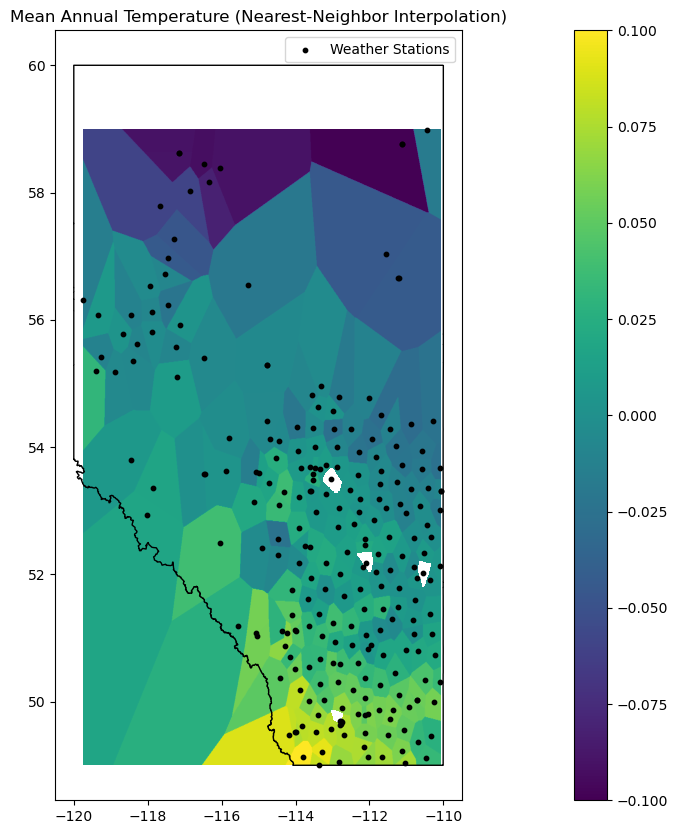

In [44]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from matplotlib import gridspec
from rasterio.plot import show

# Step 1: Load the CSV file and extract necessary columns
file_path = 'C:\\Users\\User\\Downloads\\en_climate_summaries_AB_12-2019.csv'
data = pd.read_csv(file_path)

if not {'Lat', 'Long', 'Tm'}.issubset(data.columns):
    raise ValueError("Required columns ('Lat', 'Long', 'Tm') are missing.")

# Convert to GeoDataFrame for geospatial operations
data = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.Long, data.Lat),
    crs="EPSG:4326",
)

# Step 2: Create a grid for interpolation
x_min, x_max = data['Long'].min(), data['Long'].max()
y_min, y_max = data['Lat'].min(), data['Lat'].max()

# Define grid resolution
grid_res = 0.01  # Degrees
grid_x, grid_y = np.meshgrid(
    np.arange(x_min, x_max, grid_res),
    np.arange(y_min, y_max, grid_res)
)

# Step 3: Perform Nearest-Neighbor Interpolation
points = data[['Long', 'Lat']].values
values = data['Tm'].values
grid_z_nn = griddata(points, values, (grid_x, grid_y), method='nearest')

# Step 4: Load the shapefile for boundary
shapefile_path = r"C:\Users\User\OneDrive\Desktop\lab5shape.shp"
boundary = gpd.read_file(shapefile_path)

# Step 5: Visualize the Nearest-Neighbor Interpolation
norm = mpl.colors.Normalize(vmin=values.min(), vmax=values.max(), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

# Create the figure and subplots
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(14, 10)
ax_cb = plt.subplot2grid((14, 20), (0, 15), colspan=1, rowspan=14)
ax_map = plt.subplot2grid((14, 20), (0, 0), colspan=14, rowspan=14)

# Add colorbar
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cm.viridis, norm=norm, orientation="vertical")
mpl.rcParams.update({"font.size": 10})

# Plot the interpolated temperature surface
interpolation = ax_map.imshow(
    grid_z_nn,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap=cm.viridis,
    aspect='auto',
)

# Overlay the data points
ax_map.scatter(data.Long, data.Lat, c='black', s=10, label='Weather Stations')

# Add shapefile boundaries
boundary.plot(ax=ax_map, edgecolor="black", facecolor="none", linewidth=1)

# Title and legend
ax_map.set_title("Mean Annual Temperature (Nearest-Neighbor Interpolation)")
ax_map.legend()

plt.show()


In [45]:
# Clean data by removing NaNs to ensure consistency in lengths
data_cleaned = data.dropna(subset=['Lat', 'Long', 'Tm'])

# Points and values should come from the same dataset
points = data_cleaned[['Long', 'Lat']].values
values = data_cleaned['Tm'].values


In [46]:
print(f"Length of points: {len(points)}")
print(f"Length of values: {len(values)}")


Length of points: 239
Length of values: 239


In [47]:
# Perform interpolation
interpolated_values = griddata(points, values, points, method='nearest')

# Verify the length of interpolated values
print(f"Length of interpolated_values: {len(interpolated_values)}")

# Ensure that interpolated_values and values have the same length
if len(values) != len(interpolated_values):
    raise ValueError("Interpolated values and original values have inconsistent lengths.")


Length of interpolated_values: 239


In [24]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE between original and interpolated values
rmse = np.sqrt(mean_squared_error(values, interpolated_values))

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Root Mean Squared Error (RMSE): 0.0194


In [37]:
# Check for missing values
data = data.dropna(subset=['Lat', 'Long', 'Tm'])

# Ensure coordinates are within the expected range (e.g., valid latitudes and longitudes)
x_rain = data['Long'].values
y_rain = data['Lat'].values
value_rain = data['Tm'].values


In [50]:
print("Columns with NaN values:")
print(data.isnull().sum())


Columns with NaN values:
Long             0
Lat              0
Stn_Name         0
Clim_ID          0
Prov_or_Ter      0
Tm               4
DwTm             4
D              231
Tx               4
DwTx             4
Tn               4
DwTn             4
S              224
DwS            224
S%N            236
P               14
DwP             14
P%N            234
S_G            191
Pd              14
BS             243
DwBS           243
BS%            243
HDD              4
CDD              4
geometry         0
dtype: int64


In [51]:
data = data.dropna(subset=['Long', 'Lat', 'Tm'])


In [52]:
print("Remaining data points:", len(data))


Remaining data points: 239


In [53]:
lons = data['Long'].values
lats = data['Lat'].values
temps = data['Tm'].values

if len(lons) < 3:
    raise ValueError("Not enough valid data points for Kriging.")


In [54]:
# Set up and execute Kriging
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt

# Create Kriging model
ok = OrdinaryKriging(
    lons, lats, temps,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False
)

# Generate grid
grid_x, grid_y = np.meshgrid(
    np.linspace(lons.min(), lons.max(), 100),
    np.linspace(lats.min(), lats.max(), 100)
)

# Interpolate
grid_z, ss = ok.execute("grid", grid_x[0], grid_y[:, 0])

# Plot

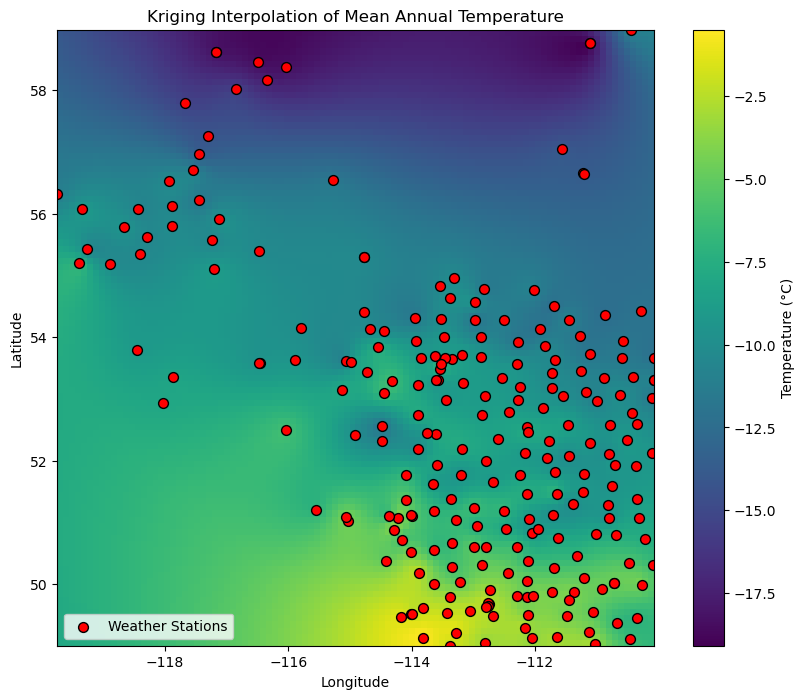

In [55]:
import matplotlib.pyplot as plt

# Plot the Kriging results
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the interpolated surface
c = ax.imshow(
    grid_z,
    extent=(lons.min(), lons.max(), lats.min(), lats.max()),
    origin="lower",
    cmap="viridis"
)
plt.colorbar(c, ax=ax, label="Temperature (°C)")  # Add colorbar

# Overlay the weather station points
ax.scatter(lons, lats, c="red", edgecolor="black", s=50, label="Weather Stations")

# Add titles and labels
ax.set_title("Kriging Interpolation ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add a legend
ax.legend()

plt.show()


In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Perform kriging interpolation at the original data points
z_pred, ss_pred = ok.execute("points", lons, lats)  # Predicted values at the original points

# Compute RMSE
rmse = np.sqrt(mean_squared_error(temps, z_pred))

# Print the result
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")


Root Mean Square Error (RMSE): 0.0137


RMSE of IDW Interpolation: 0.0137


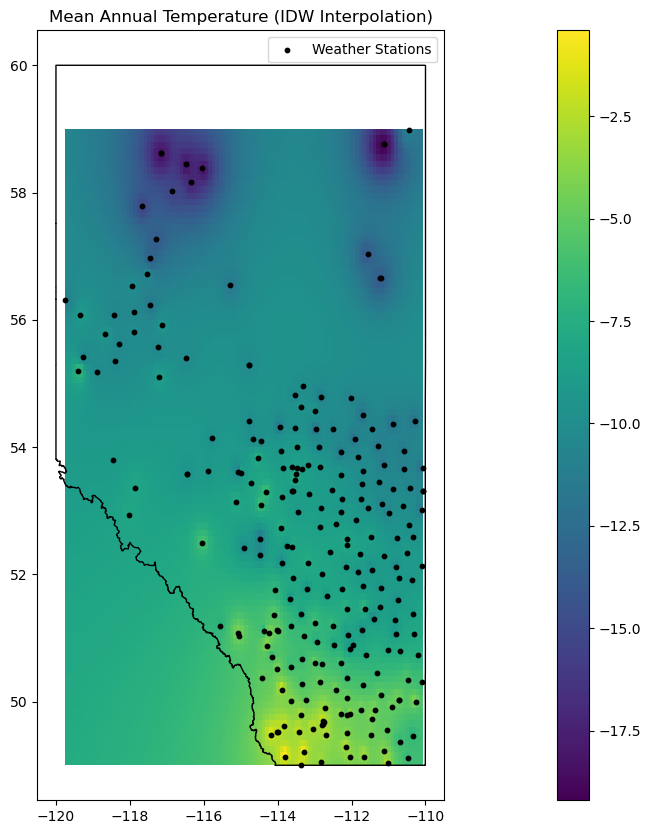

In [57]:
from sklearn.metrics import mean_squared_error

# Step 3: Perform IDW Interpolation
def idw_interpolation(points, values, grid_x, grid_y, power=2):
    """
    Perform Inverse Distance Weighting (IDW) interpolation.

    Args:
        points (array): Nx2 array of coordinates.
        values (array): N array of values at the points.
        grid_x (array): X-coordinates of the grid.
        grid_y (array): Y-coordinates of the grid.
        power (int): Power parameter for IDW.

    Returns:
        grid_z_idw: Interpolated values over the grid.
    """
    grid_z_idw = np.zeros(grid_x.shape)
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            # Calculate distances
            distances = np.sqrt((points[:, 0] - grid_x[i, j])**2 + (points[:, 1] - grid_y[i, j])**2)
            # Avoid division by zero
            distances[distances == 0] = 1e-12
            # Weights for each point
            weights = 1 / (distances**power)
            # Weighted average
            grid_z_idw[i, j] = np.sum(weights * values) / np.sum(weights)
    return grid_z_idw

# Perform IDW Interpolation
grid_z_idw = idw_interpolation(points, values, grid_x, grid_y)

# Step 6: Calculate RMSE between observed and predicted points
# Predict temperature values at station locations using IDW
predicted_temps = []
for i in range(len(points)):
    distances = np.sqrt((points[:, 0] - points[i, 0])**2 + (points[:, 1] - points[i, 1])**2)
    distances[distances == 0] = 1e-12
    weights = 1 / (distances**2)
    predicted_temps.append(np.sum(weights * values) / np.sum(weights))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(values, predicted_temps))
print(f"RMSE of IDW Interpolation: {rmse:.4f}")

# Step 7: Visualize the IDW Interpolation
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(14, 10)
ax_cb = plt.subplot2grid((14, 20), (0, 15), colspan=1, rowspan=14)
ax_map = plt.subplot2grid((14, 20), (0, 0), colspan=14, rowspan=14)

# Add colorbar
norm = mpl.colors.Normalize(vmin=values.min(), vmax=values.max(), clip=True)
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cm.viridis, norm=norm, orientation="vertical")
mpl.rcParams.update({"font.size": 10})

# Plot the interpolated temperature surface
interpolation = ax_map.imshow(
    grid_z_idw,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap=cm.viridis,
    aspect='auto',
)

# Overlay the data points
ax_map.scatter(data.Long, data.Lat, c='black', s=10, label='Weather Stations')

# Add shapefile boundaries
boundary.plot(ax=ax_map, edgecolor="black", facecolor="none", linewidth=1)

# Title and legend
ax_map.set_title("Mean Annual Temperature (IDW Interpolation)")
ax_map.legend()

plt.show()
